In [1]:
#import libarary
import pandas as pd
import numpy as np
import html 
import re
import warnings 
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn_extra.cluster import KMedoids
#Step3 and Step4
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer #for vectorize text into sparse matrix 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from io import StringIO
from sklearn.model_selection import cross_val_score
from IPython.display import display
import snowballstemmer
import itertools

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('Indonesian')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eBdesk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eBdesk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading Indonesian: Package 'Indonesian' not found
[nltk_data]     in index


False

In [3]:
#load the data
df=pd.read_csv("C:/Users/eBdesk/Desktop/SupervisorConf/media/dataTraining3/3rd/final/data.csv")

In [4]:
df

,sumber,link,created_at,category,content
0,tempo.co,http://bisnis.tempo.co/read/1415614/meski-dipr...,2020-12-18 05:50:28,business and economy,Menjelang hari raya Natal dan Tahun Baru 2021 ...
1,medcom.id,https://video.medcom.id/video-advertorial/GKdp...,2020-12-18 05:05:51,business and economy,Indonesia merupakan negara kepulauan dengan le...
2,tribun news,https://www.tribunnews.com/bisnis/2020/12/18/l...,2020-12-18 05:22:13,business and economy,Simak langkah melakukan klaim token listrik gr...
3,wartakotalive,https://wartakota.tribunnews.com/2020/12/18/up...,2020-12-18 03:15:24,business and economy,-- Berikut ini update harga emas hari ini seba...
4,medcom.id,https://www.medcom.id/ekonomi/global/zNA3p8nk-...,2020-12-18 05:21:28,business and economy,Federal Reserve memutuskan untuk sedikit menai...
...,...,...,...,...,...
5190,tribun news,https://www.tribunnews.com/superskor/2020/12/0...,2020-11-30 22:48:36,sports,Media Spanyol AS mengklaim Chelsea menjadi klu...
5191,suara.com,https://sumut.suara.com/read/2020/12/01/060000...,2020-11-30 23:06:51,sports,Manchester United melakoni comeback fenomenal ...
5192,republika,https://republika.co.id/berita/qkmtj0313/onepr...,2020-11-30 23:10:04,sports,Ajang beladiri Mixed Martial Arts terbesar di ...
5193,republika,https://republika.co.id/berita/qkmtoe313/sirku...,2020-11-30 23:10:04,sports,Sirkuit Mandalika Indonesia resmi masuk dalam ...


In [9]:
katagori = df['category'].value_counts()
katagori

sports                    541
law and crimes            538
business and economy      534
health and medicine       525
politics and election     522
entertainment             517
science and technology    509
lifestyle                 506
education                 503
disaster and accident     500
Name: category, dtype: int64

In [10]:
nanvaluekategori = df['category'].isnull().sum()
nanvaluecontent = df['content'].isnull().sum()
nanvaluekategori,nanvaluecontent

(0, 0)

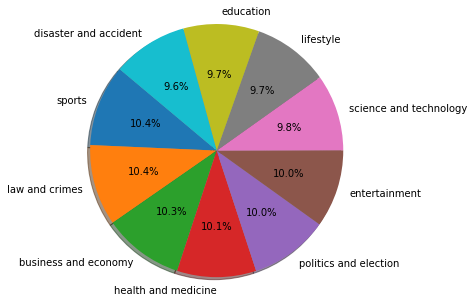

In [11]:
#(menampilkan jumlah data dlm grafik)
plt.figure(figsize=(5,5))
labels = katagori.index.tolist()
sizes = katagori
explode = (0,0,0,0,0,0,0,0,0,0) 
# Plot
plt.pie(sizes, explode=explode, labels=labels,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

In [12]:
NewsData = df.drop(columns=['sumber', 'link','created_at'])
NewsData

,category,content
0,business and economy,Menjelang hari raya Natal dan Tahun Baru 2021 ...
1,business and economy,Indonesia merupakan negara kepulauan dengan le...
2,business and economy,Simak langkah melakukan klaim token listrik gr...
3,business and economy,-- Berikut ini update harga emas hari ini seba...
4,business and economy,Federal Reserve memutuskan untuk sedikit menai...
...,...,...
5190,sports,Media Spanyol AS mengklaim Chelsea menjadi klu...
5191,sports,Manchester United melakoni comeback fenomenal ...
5192,sports,Ajang beladiri Mixed Martial Arts terbesar di ...
5193,sports,Sirkuit Mandalika Indonesia resmi masuk dalam ...


In [13]:
NewsData['content'] = NewsData['content'].str.lower()
NewsData

,category,content
0,business and economy,menjelang hari raya natal dan tahun baru 2021 ...
1,business and economy,indonesia merupakan negara kepulauan dengan le...
2,business and economy,simak langkah melakukan klaim token listrik gr...
3,business and economy,-- berikut ini update harga emas hari ini seba...
4,business and economy,federal reserve memutuskan untuk sedikit menai...
...,...,...
5190,sports,media spanyol as mengklaim chelsea menjadi klu...
5191,sports,manchester united melakoni comeback fenomenal ...
5192,sports,ajang beladiri mixed martial arts terbesar di ...
5193,sports,sirkuit mandalika indonesia resmi masuk dalam ...


In [14]:
# untuk menghapus apapun selain text 
NewsData['content']=NewsData['content'].str.replace("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|([0-9])","")
#step tokenize
NewsData['content'] = NewsData['content'].apply(nltk.word_tokenize)
NewsData

,category,content
0,business and economy,"[menjelang, hari, raya, natal, dan, tahun, bar..."
1,business and economy,"[indonesia, merupakan, negara, kepulauan, deng..."
2,business and economy,"[simak, langkah, melakukan, klaim, token, list..."
3,business and economy,"[berikut, ini, update, harga, emas, hari, ini,..."
4,business and economy,"[federal, reserve, memutuskan, untuk, sedikit,..."
...,...,...
5190,sports,"[media, spanyol, as, mengklaim, chelsea, menja..."
5191,sports,"[manchester, united, melakoni, comeback, fenom..."
5192,sports,"[ajang, beladiri, mixed, martial, arts, terbes..."
5193,sports,"[sirkuit, mandalika, indonesia, resmi, masuk, ..."


In [15]:
data = pd.read_csv("C:\\Users\\eBdesk\\Documents\\Untitled Folder\\indonesian_stopword.txt")
data['\'\'']
NewsData['content'] = NewsData['content'].apply(lambda x: [y for y in x if y not in data['\'\''].tolist()])
stopword = NewsData
stopword

,category,content
0,business and economy,"[menjelang, raya, natal, pt, pertamina, perser..."
1,business and economy,"[indonesia, negara, kepulauan, pulau, geografi..."
2,business and economy,"[simak, langkah, klaim, token, listrik, gratis..."
3,business and economy,"[update, harga, emas, panduan, harga, jual, em..."
4,business and economy,"[federal, reserve, memutuskan, menaikkan, perk..."
...,...,...
5190,sports,"[media, spanyol, as, mengklaim, chelsea, klub,..."
5191,sports,"[manchester, united, melakoni, comeback, fenom..."
5192,sports,"[ajang, beladiri, mixed, martial, arts, terbes..."
5193,sports,"[sirkuit, mandalika, indonesia, resmi, masuk, ..."


In [16]:
#untuk mengubah field category menjadi angka untuk mempercepat proses
NewsData2 = sorted(NewsData['category'].unique())
NewsData_mapping = dict(zip(NewsData2, range(0, len(NewsData2) + 1)))
NewsData['category']  = NewsData['category'].map(NewsData_mapping).astype(int)
NewsData_mapping = NewsData
NewsData_mapping

,category,content
0,0,"[menjelang, raya, natal, pt, pertamina, perser..."
1,0,"[indonesia, negara, kepulauan, pulau, geografi..."
2,0,"[simak, langkah, klaim, token, listrik, gratis..."
3,0,"[update, harga, emas, panduan, harga, jual, em..."
4,0,"[federal, reserve, memutuskan, menaikkan, perk..."
...,...,...
5190,9,"[media, spanyol, as, mengklaim, chelsea, klub,..."
5191,9,"[manchester, united, melakoni, comeback, fenom..."
5192,9,"[ajang, beladiri, mixed, martial, arts, terbes..."
5193,9,"[sirkuit, mandalika, indonesia, resmi, masuk, ..."


In [17]:
NewsData2

['business and economy',
 'disaster and accident',
 'education',
 'entertainment',
 'health and medicine',
 'law and crimes',
 'lifestyle',
 'politics and election',
 'science and technology',
 'sports']

In [18]:
NewsData3 = NewsData
NewsData3['content'] = NewsData['content'].str.join(" ")
NewsData3.head()

,category,content
0,0,menjelang raya natal pt pertamina persero meng...
1,0,indonesia negara kepulauan pulau geografis ind...
2,0,simak langkah klaim token listrik gratis disko...
3,0,update harga emas panduan harga jual emas mamp...
4,0,federal reserve memutuskan menaikkan perkiraan...


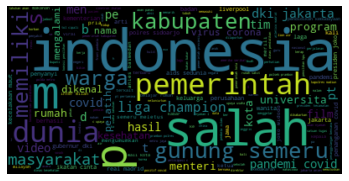

In [19]:
#wordcloud untuk mengetahui text apa saja yang sering keluar
text = NewsData3['content'].to_string()
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [61]:
#stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()
#stemming process
i=0
stm = NewsData
stm_tfidf=NewsData
NewsData
import array

In [ ]:
i=0
list1 = []
for index,row in tqdm(stm.iterrows()):
  i=i+1
  res= stemmer.stem(row['content'])
  list1.append(res)
stm_tfidf['content']=list1

In [20]:
import array
for index,row in NewsData.iterrows():
  print(row['content'])

menjelang raya natal pt pertamina persero mengaktifkan satuan tugas semenjak tanggal pekan tanggal wilayah jawa pertamina memprediksi peningkatan konsumsi bahan bakar pesawat udara avtur jelang periode ratarata harian kiloliter kl kl penanggung unit manager communication relations csr pertamina regional jawa arya yusa dwicandra ratarata normal pandemi covid kl catatan penurunan tertinggi bandar udara yogyakarta international airport yia adi sutjipto dimana penyaluran total pandemi covid angka kl satgas kali diprediksi angka kl normal arya keterangan tertulis bandar udara ahmad yani kota semarang adi soemarmo boyolali normal penyaluran bandara ahmad yani normal kl diprediksi berkisar angka kl natal normal adi soemarmo satgas diprediksi penyalurannya kl rataan harian normal pandemi kl arya stok avtur dimana coverage days ketahanan stok wilayah jawa pandemi covid pertamina memiliki stok bahan bakar pesawat kekhawatiran penumpang maskapai kesediaan bahan bakar
indonesia negara kepulauan pu

musibah terpaan ujian kehidupan kerap kali melanda manusia takaran sesuai kemampuannya keberadaan naluri menolong kerap mempermudah berbanding terbalik rangkasbitung banten truk pengangkut pakan ternak mengalami kecelakaan terguling warga bergegas menolong sibuk berebut menjarah pakan ternak berhamburan jalan warganet menyayangkan peristiwa ulasannya dilansir laman instagram akun resmi membagikan video singkat peristiwa langka kerumunan warga kecelakaan mengakibatkan truk pengangkut terguling jalan raya arus kendaraan terganggu tepatnya jalan raya cikande rangkasbitung banten sungguh disayangkan truk sigap ditangani pertolongan disayangkan warga mengambil kesempatan tertimpa musibah pakan ternak berhamburan sigap dimasukkan kantung plastik karung goni bagor berdesakan berebut memasukkan miris peristiwa nampak aparat kepolisian sontak mengusir warga menjarah berlari melompat seraya menendangkan kaki bentuk gertakan warga mengambil hak tercecer warga dominan lakilaki memilih menghindar m

kementerian pendidikan kebudayaan kemdikbud guru langsung mengajar materi pembelajaran tatap muka sekolah langsung guru mengajar materi perhatikan kondisi psikososial peserta didik guru direktur jenderal guru tenaga kependidikan kemendikbud iwan syahril peresmian seri webinar guru belajar menurutnya sekolah pembinaan khusus siswa pembelajaran tatap muka menekankan pembelajaran tatap muka proses belajarmengajar normal kegiatan sekolah pandemi adaptasi ditekankan siswa guru sambung perkara psikososial emosional guru siswa mental stabil belajar tatap muka membina kondisi psikososial belajar menerima konten iwan guru membiasakan protokol kesehatan siswa guru asesmen pemahaman belajar siswa sembilan belajar jarak memahami belajar tersendat pemahaman siswa semester beragam guru memetakan pembelajaran sesuai kemampuan siswa tertinggal on the right track maju butuh diferensiasi pengelolaan situasi mendikbud nadiem makarim mengizinkan sekolah dibuka pertimbangan pemerintah daerah tua survei gur

film startup diperankan bae suzy nam joo hyuk kim seon ho kang han na menanyangkan episode terakhirnya drama korea drakor tayang berhasil mencuri perhatian masyarakat indonesia saking fanatiknya penggemar film start up terbagi kelompok mendukung pasangan terbaik seo dal mi bae suzy tim pedukung han ji pyeong kim seon ho tim nam do san nam joo hyuk serial mengikuti anak muda mencoba memasuki dunia startup berjuang mewujudkan mimpi kota seoul pemandangan kota menawan menikmati kisah menyentuh hati seiring keempat mengalami cinta pendewasaan penonton sisi glamor modern korea startup memiliki pembelajaran hidup penontonnya pembelajaran hidup dipetik drakor startup kegigihan ketekunan menghianati hasil perjuangan sukses serial tokoh kegigihan ketekunannya pekerjaan diterpa seo dal mi fokus impiannya ragu menerima kritikan menjadikan seo dal mi pribadi kuat percaya seo dal mi diperankan bae suzy episode percaya berasal kalangan terpandang seo dal mi minder seo dal mi kemampuannya mempimpin p

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [21]:
#stm_tfidf = NewsData
NewsData

,category,content
0,0,menjelang raya natal pt pertamina persero meng...
1,0,indonesia negara kepulauan pulau geografis ind...
2,0,simak langkah klaim token listrik gratis disko...
3,0,update harga emas panduan harga jual emas mamp...
4,0,federal reserve memutuskan menaikkan perkiraan...
...,...,...
5190,9,media spanyol as mengklaim chelsea klub terdep...
5191,9,manchester united melakoni comeback fenomenal ...
5192,9,ajang beladiri mixed martial arts terbesar ind...
5193,9,sirkuit mandalika indonesia resmi masuk kalend...


In [22]:
# import StemmerFactory class
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def tokenize(text):
    return [stemmer.stem(text)]
#tfidf untuk no stemming
#tfidf_wm = tfidfvectorizer.fit_transform(NewsData['content'])
vectorizer2 = TfidfVectorizer(stop_words = None, tokenizer = None)
tfidf_wm = vectorizer2.fit_transform(NewsData['content'])
word_features2 = vectorizer2.get_feature_names()
print(len(word_features2))
print(word_features2[:50]) 

52224
['aa', 'aaa', 'aad', 'aadalah', 'aadhaar', 'aag', 'aaji', 'aakrab', 'aal', 'aalat', 'aalfieri', 'aaliya', 'aaliyaah', 'aaliyah', 'aam', 'aamiin', 'aamin', 'aamir', 'aan', 'aap', 'aaron', 'aarp', 'aasuhan', 'aat', 'aaui', 'aayiram', 'ab', 'abab', 'ababa', 'ababil', 'abad', 'abadi', 'abadikan', 'abah', 'abai', 'abaikan', 'abanca', 'abang', 'abangbatusari', 'abast', 'abba', 'abbas', 'abbey', 'abbott', 'abc', 'abcd', 'abd', 'abdelaziz', 'abdi', 'abdillah']


In [23]:
print(tfidf_wm.toarray())
df1 = pd.DataFrame(tfidf_wm.toarray(), columns=vectorizer2.get_feature_names())
df1

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


,aa,aaa,aad,aadalah,aadhaar,aag,aaji,aakrab,aal,aalat,...,zulkifli,zumah,zumarnis,zunnun,zuremi,zus,zwiebelrostbraten,zwirner,zy,zzooming
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
X = df1
y = NewsData['category']
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 random_state = 20,
                                                 test_size = 0.3)

In [25]:
print('The length of the trainning set are {}'.format(len(X_train)))
print('The length of the test set are {}'.format(len(X_test)))

The length of the trainning set are 3636
The length of the test set are 1559


In [26]:
kmedoids = KMedoids(n_clusters=10, random_state=1000).fit(X_train)

In [27]:
kmedoids2 = KMedoids(n_clusters=10, random_state=1000).fit(tfidf_wm)

In [28]:
kmedoids.labels_
common_words = kmedoids.cluster_centers_.argsort()[:,-10:-50:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(word_features2[word] for word in centroid))

0 : angkutan, kebijakan, natal, berlaku, didi, syafrin, antigennya, soetta, ribu, libur, kereta, diwajibkan, syarat, pemerintah, masuk, kota, wajib, kkp, surat, soekarnohatta, luhut, rhf, laut, batam, stok, terminal, biaya, hasil, gubernur, darat, molekul, pesawat, terbatas, masyarakat, keluarmasuk, pusat, udara, yustisi, mengeluh, aturan
1 : tangan, kegiatan, belajar, masker, kesehatan, pembukaan, indonesia, konfirmasi, protokol, memakai, standar, pengenalan, cuci, jarak, bergejala, negara, usia, memadai, ditingkatkan, hidup, contoh, perilaku, bertahap, keluarga, rumah, orangtua, menjaga, bersih, ikatan, rutin, sedapatnya, ringan, infeksi, mencuci, mpasi, mulainya, pembelajaran, dimarahi, tulis, dokter
2 : diperiksa, mapolda, ditreskrimum, hukum, fpi, hadir, hanif, alatas, aziz, menantunya, saksi, simpatisan, dijadwalkan, petamburan, tubagus, biro, kerumunan, massa, kamneg, kuasa, subdit, akad, nikah, pemeriksaan, alasan, konfirmasi, taktis, beliau, surat, siang, mengerti, jadwalkan, 

In [29]:
kmedoids.inertia_

4840.992650896517

In [30]:
def unique(list1):
 
    # intilize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    for x in unique_list:
        print (x)

In [31]:
unique(kmedoids.labels_)

3
6
1
5
4
7
9
8
0
2


In [32]:
kmedoids.cluster_centers_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
y_pred1 = kmedoids.predict(X_test)

In [34]:
unique(y_pred1)

3
5
8
6
7
1
0
9
4
2


In [35]:
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    print(contingency_matrix)
    print(np.sum(contingency_matrix))
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

In [36]:
purity_score(y_test,y_pred1)

[[ 30  23   2   9  30   9  12   4  14  35]
 [ 19   8  13  95   6   2   1   0   1   3]
 [  3  96   1   3   7   9  10   1   4  13]
 [  5  54   4  11  11  20   4  15   8  10]
 [  5  51   1   4  47  23  22   0   9   6]
 [ 11  28  50  18  14  20   5   0  10  20]
 [  9  45   0  26  12  13   6   2  10  23]
 [ 32   9   6  12  11  17   7   0  13  42]
 [ 12  32   1  15  35  12   9   0  15  13]
 [  2   8   0   1   6   8   4 135   2   5]]
1559


0.35728030788967285

In [39]:
from sklearn.metrics import silhouette_samples, silhouette_score
silhouette_avg = silhouette_score(X_test, y_pred1)
print(silhouette_avg)

0.008082076028577244


In [40]:
sample_silhouette_values = silhouette_samples(X_test, y_pred1)
for i in range(10):
    ith_cluster_silhouette_values = sample_silhouette_values[y_pred1 == i]
    print(np.mean(ith_cluster_silhouette_values))

0.008035540018528844
0.0009384489794724193
0.02004584124699652
0.013340282855630043
0.004576070251186928
-0.0005130120001776701
-0.0009370963913163197
0.03932883957148869
0.006642331760767997
-0.001965768444672104


In [41]:
sw = []
purity = []
from tqdm.notebook import tqdm as tqdm
import pickle
for i in tqdm(range(2, 11)):
    kmedoids = KMedoids(n_clusters = i, random_state = 0)
    kmedoids.fit(X_train)
    filename = 'C:\\Users\\eBdesk\\Documents\\Untitled Folder\\5k-with out stemming II\\5kdata-cluster-'+str(i)+'.sav'
    pickle.dump(kmedoids, open(filename, 'wb'))
    y_pred1 = kmedoids.fit_predict(X_test)
    silhouette_avg = silhouette_score(X_test, y_pred1)
    purity.append(purity_score(y_test,y_pred1))
    sw.append(silhouette_avg)

[[154  14]
 [139   9]
 [137  10]
 [ 76  66]
 [153  15]
 [165  11]
 [119  27]
 [141   8]
 [125  19]
 [ 16 155]]
1559
[[138   7  23]
 [ 19   0 129]
 [130  10   7]
 [ 55  50  37]
 [138  10  20]
 [118   4  54]
 [ 73   8  65]
 [122   3  24]
 [103  10  31]
 [ 15 152   4]]
1559
[[127   6  21  14]
 [ 11   0  61  76]
 [123   8  13   3]
 [ 48  45  18  31]
 [126   5  24  13]
 [102   2  36  36]
 [ 62   7  30  47]
 [116   3   9  21]
 [ 94   7  22  21]
 [ 13 151   4   3]]
1559
[[109   6  17   7  29]
 [  7   0  35  41  65]
 [117   7  12   2   9]
 [ 38  39  13  23  29]
 [121   2  16  12  17]
 [ 80   1  22  16  57]
 [ 53   4  29  32  28]
 [111   3   7  21   7]
 [ 82   5  16  17  24]
 [ 12 151   3   2   3]]
1559
[[  4  11  63  14   6  70]
 [  0  34   7  65  41   1]
 [  1   9  88   5   2  42]
 [ 35  10  29  21  17  30]
 [  0  15 102  13  10  28]
 [  0  19  62  47  16  32]
 [  4  24  45  27  27  19]
 [  0   7  66   2  17  57]
 [  4  11  56  18  14  41]
 [148   3   6   3   2   9]]
1559
[[  3  10  35  12   

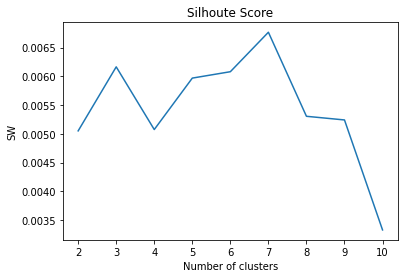

[0.005051372891804877, 0.006165306569937962, 0.005074583895317779, 0.005969696466530986, 0.006080900045039698, 0.006767592273830951, 0.005305138903282689, 0.005241507735218688, 0.003328108853846743]


In [42]:
plt.plot(range(2, 11), sw)
plt.title('Silhoute Score')
plt.xlabel('Number of clusters')
plt.ylabel('SW')      #within cluster sum of squares
plt.show()
print(sw)

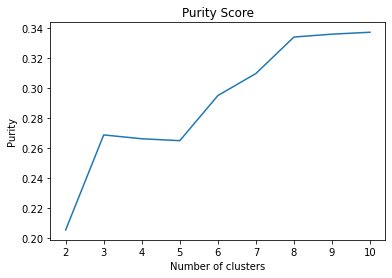

[0.20525978191148173, 0.2687620269403464, 0.2661962796664529, 0.2649134060295061, 0.29506093649775494, 0.3098139833226427, 0.3341885824246312, 0.3361128928800513, 0.3373957665169981]


In [43]:
plt.plot(range(2, 11), purity)
plt.title('Purity Score')
plt.xlabel('Number of clusters')
plt.ylabel('Purity')      #within cluster sum of squares
plt.show()
print(purity)